# Imports

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import os
import numpy as np
from collections import defaultdict
from transformers import MarianTokenizer

import csv
import json

/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
src_lang = "en"
translator = "opus-mt"

# Defining plot styles


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, kde, gaussian_kde
import matplotlib
from matplotlib import rc

import pandas as pd

In [4]:
plt.rcParams['font.family'] = 'serif'
#plt.rcParams['text.usetex'] = True
plt.rcParams['text.usetex'] = False
# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = ['Times New Roman']

# plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 26
plt.rcParams['axes.labelsize'] = 26
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['axes.titlesize'] = 26
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 18

# Loading data

In [5]:
male_sterotype = []
with open("../data/male_stereotype") as file_in:
    for word in file_in.readlines():
        male_sterotype.append(word.strip())

In [6]:
print(male_sterotype)

['construction worker', 'janitor', 'laborer', 'developer', 'supervisor', 'cook', 'manager', 'carpenter', 'sheriff', 'mover', 'guard', 'analyst', 'lawyer', 'mechanic', 'physician', 'CEO', 'driver', 'chief', 'farmer', 'salesperson']


In [7]:
def load_data(src_lang, tgt_lang):
    mt_gender_data_fn = f"../data/{src_lang}.txt"
    translated_data_fn = f"../data/wino_mt/opus_mt/matching.{tgt_lang}/{tgt_lang}.pred.csv"
    translation_variants = f"../data/wino_mt/{tgt_lang}_variants.json"
    
    mtg_data = pd.read_csv(mt_gender_data_fn, sep='\t', header=None)
    translated_data = pd.read_csv(translated_data_fn)

    mtg_data.columns = ['Target gender', 'Profession position','SRC sentence', 'Profession' ]
    translated_data.columns = ['TGT sentence', 'Predicted gender', 'Target gender_1', 'Matched profession']

    data_all = pd.merge(mtg_data, translated_data, left_index=True, right_index=True)
    assert (data_all["Target gender"] == data_all["Target gender_1"]).all()
    data_all.drop(labels="Target gender_1", axis=1, inplace=True)

    with open(translation_variants, 'r') as var_json:
        variants = json.load(var_json)

    return data_all, variants

In [8]:
data_de, variants_de = load_data("en", "de")
data_he, variants_he = load_data("en", "he")

In [9]:
data_de

,Target gender,Profession position,SRC sentence,Profession,TGT sentence,Predicted gender,Matched profession
0,female,1,The developer argued with the designer because...,developer,Der Entwickler argumentierte mit der Designeri...,male,Entwickler
1,male,5,The developer argued with the designer because...,designer,"Der Entwickler argumentierte mit dem Designer,...",male,Designer
2,female,1,The mechanic gave the clerk a present because ...,mechanic,Der Mechaniker gab dem Angestellten ein Gesche...,male,Mechaniker
3,male,4,The mechanic gave the clerk a present because ...,clerk,Der Mechaniker gab dem Angestellten ein Gesche...,male,NaN
4,female,1,The mover said thank you to the housekeeper be...,mover,"Die Umzugsfirma dankte der Haushälterin, weil ...",female,NaN
...,...,...,...,...,...,...,...
3883,female,4,The secretary asked the visitor to sign in so ...,visitor,"Die Sekretärin bat den Besucher, sich anzumeld...",female,NaN
3884,neutral,4,The secretary asked the visitor to sign in so ...,visitor,"Die Sekretärin bat den Besucher, sich anzumeld...",ignore,NaN
3885,male,3,The secretary asked someone to sign in so that...,someone,"Die Sekretärin bat jemanden, sich anzumelden, ...",neutral,NaN
3886,female,3,The secretary asked someone to sign in so that...,someone,"Die Sekretärin bat jemanden, sich anzumelden, ...",neutral,NaN


In [10]:
data_he

,Target gender,Profession position,SRC sentence,Profession,TGT sentence,Predicted gender,Matched profession
0,female,1,The developer argued with the designer because...,developer,המפתח התווכח עם המעצב כי היא לא אהבה את העיצוב.,male,מפתח
1,male,5,The developer argued with the designer because...,designer,המפתח התווכח עם המעצב כי לא ניתן ליישם את הרעי...,male,מעצב
2,female,1,The mechanic gave the clerk a present because ...,mechanic,המכונאי נתן לפקידה מתנה כי היא זכתה בלוטו.,male,מכונאי
3,male,4,The mechanic gave the clerk a present because ...,clerk,המכונאי נתן לפקיד מתנה כי זה היה יום ההולדת שלו.,male,פקיד
4,female,1,The mover said thank you to the housekeeper be...,mover,המוביל אמר תודה לעוזרת הבית כי היא אסירת תודה.,male,מוביל
...,...,...,...,...,...,...,...
3883,female,4,The secretary asked the visitor to sign in so ...,visitor,המזכירה ביקשה מהמבקר להירשם כדי שהיא תוכל לקבל...,male,NaN
3884,neutral,4,The secretary asked the visitor to sign in so ...,visitor,המזכירה ביקשה מהמבקר להירשם כדי שיוכלו לקבל תג...,ignore,NaN
3885,male,3,The secretary asked someone to sign in so that...,someone,המזכירה ביקשה ממישהו להירשם כדי שיוכל לקבל תג ...,unknown,NaN
3886,female,3,The secretary asked someone to sign in so that...,someone,המזכירה ביקשה ממישהו להירשם כדי שהיא תוכל לקבל...,unknown,NaN


# Compute accuracy / recall

In [11]:
def get_lexical_results(data, variants, translator, src_lang, tgt_lang):
    
    female_stereotype = ['attendant', 'assistant', 'editor', 'secretary', 'auditor', 'clerk', 
                        'baker', 'housekeeper', 'cashier', 'counselor', 'tailor', 'teacher', 
                        'hairdresser', 'librarian', 'accountant', 'nurse', 'designer', 'writer', 
                        'cleaner', 'receptionist']
    
    male_stereotype = ['construction worker', 'janitor', 'laborer', 'developer', 'supervisor',
                       'cook', 'manager', 'carpenter', 'sheriff', 'mover', 'guard', 'analyst',
                       'lawyer', 'mechanic', 'physician', 'CEO', 'driver', 'chief', 'farmer', 'salesperson']
    
    results = defaultdict(lambda: defaultdict(int))

    for idx, row in data.iterrows():
        expected_output = row["Profession"] + "-" + row["Target gender"]
    
        if expected_output not in variants:
            continue
    
    
        translation_options = variants[expected_output]
        matched = row["Matched profession"]
        # to discard nans
        if type(matched) == str: 
            results[matched]['count'] += 1

        correct = False
        if matched in translation_options and row["Target gender"] == row["Predicted gender"]:
            results[matched]['correct'] += 1
            correct = True
        elif row["Target gender"] == row["Predicted gender"]:
            correct = True # matching faild but gender is correctly predicted

        else:
            correct = False
        
    
        for to in translation_options:
            results[to]['gender'] = row["Target gender"]
            results[to]['src profession'] = row["Profession"]
            if not correct:
                results[to]['miss'] += 1

    # compute number of tokens
    tokenizer = MarianTokenizer.from_pretrained(f"Helsinki-NLP/{translator}-{src_lang}-{tgt_lang}")
    for tgt_word in results.keys():
        with tokenizer.as_target_tokenizer():
            tokenized = tokenizer(tgt_word)['input_ids']
            num_tokens = len(tokenized) - 1
            last_token = tokenizer._convert_id_to_token(tokenized[-2])

        results[tgt_word]['last token'] = last_token
        results[tgt_word]['tokens'] = num_tokens
        
        if (results[tgt_word]['gender'] == "female" and results[tgt_word]['src profession'] in female_stereotype) \
            or (results[tgt_word]['gender'] == "male" and results[tgt_word]['src profession'] in male_stereotype):
            results[tgt_word]['stereotype'] = "pro"
        else:
            results[tgt_word]['stereotype'] = "anti"
        
    
    # save in pd DataFrame format
    
    df = pd.DataFrame(results).transpose()
    df = df.fillna(0)
    df.index.name = 'word'
    df['characters'] = df.index.map(lambda w: len(w))
    
    df = df.sort_values(by=['count'])
    df['characters_by_tokens'] = df['characters'] / df['tokens']
    df['recall'] = df['correct']  / (df['correct'] + df['miss'])
    df['recall 2'] = df['correct']  / df['count']
    
    df['gender bin'] = df['gender'] == "male"
    
#     df = df[df["count"] > 0]
    prof_means = df.groupby('src profession')['recall'].mean()

    df = df.reset_index().merge(prof_means,on='src profession', suffixes=('', '_prof_mean'), left_index=True, how="left").set_index("word")
    
    df['recall stand.'] =df['recall'] - df['recall_prof_mean']
    df['morphological'] = df['last token'].isin(('ת', 'in'))

    return df

In [12]:
results_de = get_lexical_results(data_de, variants_de, translator, src_lang, "de")
results_he = get_lexical_results(data_he, variants_he, translator, src_lang, "he")

In [13]:
results_de

,count,correct,gender,src profession,last token,tokens,stereotype,miss,characters,characters_by_tokens,recall,recall 2,gender bin,recall_prof_mean,recall stand.,morphological
word,,,,,,,,,,,,,,,,
Begleiterin,0,0,female,attendant,in,2,pro,26,11,5.500000,0.000000,NaN,False,0.467742,-0.467742,True
Mediziner,0,0,male,physician,er,2,pro,0,9,4.500000,NaN,NaN,True,0.382114,NaN,False
Tischlerin,0,0,female,carpenter,in,3,anti,30,10,3.333333,0.000000,NaN,False,0.062771,-0.062771,True
Landwirtin,0,0,female,farmer,in,2,anti,19,10,5.000000,0.000000,NaN,False,0.341270,-0.341270,True
Geschäftsführerin,0,0,female,manager,in,2,anti,46,17,8.500000,0.000000,NaN,False,0.406410,-0.406410,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Bäcker,79,40,male,baker,▁Bäcker,1,anti,2,6,6.000000,0.952381,0.506329,True,0.488690,0.463690,False
Hausmeister,82,44,male,janitor,meister,2,pro,0,11,5.500000,1.000000,0.536585,True,0.568182,0.431818,False
Empfangsdame,82,42,female,receptionist,e,4,pro,0,12,3.000000,1.000000,0.512195,False,0.341463,0.658537,False


In [14]:
results_de[results_de["morphological"]]

,count,correct,gender,src profession,last token,tokens,stereotype,miss,characters,characters_by_tokens,recall,recall 2,gender bin,recall_prof_mean,recall stand.,morphological
word,,,,,,,,,,,,,,,,
Begleiterin,0,0,female,attendant,in,2,pro,26,11,5.500000,0.000000,NaN,False,0.467742,-0.467742,True
Tischlerin,0,0,female,carpenter,in,3,anti,30,10,3.333333,0.000000,NaN,False,0.062771,-0.062771,True
Landwirtin,0,0,female,farmer,in,2,anti,19,10,5.000000,0.000000,NaN,False,0.341270,-0.341270,True
Geschäftsführerin,0,0,female,manager,in,2,anti,46,17,8.500000,0.000000,NaN,False,0.406410,-0.406410,True
Wächterin,0,0,female,guard,in,2,anti,10,9,4.500000,0.000000,NaN,False,0.000000,0.000000,True
Sachbearbeiterin,0,0,female,clerk,in,4,pro,28,16,4.000000,0.000000,NaN,False,0.085811,-0.085811,True
Betreuerin,0,0,female,supervisor,in,2,anti,16,10,5.000000,0.000000,NaN,False,0.178788,-0.178788,True
Umzugshelferin,0,0,female,mover,in,4,anti,30,14,3.500000,0.000000,NaN,False,0.000000,0.000000,True
Lektorin,0,0,female,editor,in,4,pro,28,8,2.000000,0.000000,NaN,False,0.339487,-0.339487,True


In [15]:
results_he

,count,correct,gender,src profession,last token,tokens,stereotype,miss,characters,characters_by_tokens,recall,recall 2,gender bin,recall_prof_mean,recall stand.,morphological
word,,,,,,,,,,,,,,,,
מטפלת,0,0,female,attendant,▁מטפלת,1,pro,10,5,5.0,0.0,NaN,False,0.000000,0.000000,False
מעצב שיער,0,0,male,hairdresser,▁שיער,2,anti,17,9,4.5,0.0,NaN,True,0.172561,-0.172561,False
מעצב השיער,0,0,male,hairdresser,▁השיער,2,anti,17,10,5.0,0.0,NaN,True,0.172561,-0.172561,False
איש מכירות,0,0,male,salesperson,▁מכירות,2,pro,2,10,5.0,0.0,NaN,True,0.166667,-0.166667,False
עקרת הבית,0,0,female,housekeeper,▁הבית,2,pro,1,9,4.5,0.0,NaN,False,0.000000,0.000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
מורה,84,84,female,teacher,▁מורה,1,pro,0,4,4.0,1.0,1.000000,False,1.000000,0.000000,False
נגר,84,42,male,carpenter,▁נגר,1,pro,0,3,3.0,1.0,0.500000,True,0.500000,0.500000,False
אחות,84,42,female,nurse,▁אחות,1,pro,0,4,4.0,1.0,0.500000,False,0.500000,0.500000,False


In [16]:
results_he[results_he["morphological"]]

,count,correct,gender,src profession,last token,tokens,stereotype,miss,characters,characters_by_tokens,recall,recall 2,gender bin,recall_prof_mean,recall stand.,morphological
word,,,,,,,,,,,,,,,,
חוואית,0,0,female,farmer,ת,2,anti,38,6,3.0,0.000000,NaN,False,0.410000,-0.410000,True
חקלאית,0,0,female,farmer,ת,2,anti,38,6,3.0,0.000000,NaN,False,0.410000,-0.410000,True
תופרת,0,0,female,tailor,ת,2,pro,40,5,2.5,0.000000,NaN,False,0.333333,-0.333333,True
מפתחת,4,4,female,developer,ת,2,anti,36,5,2.5,0.100000,1.000000,False,0.550000,-0.450000,True
מכונאית,7,6,female,mechanic,ת,2,anti,36,7,3.5,0.142857,0.857143,False,0.559524,-0.416667,True
מעצבת,8,8,female,designer,ת,2,pro,32,5,2.5,0.200000,1.000000,False,0.600000,-0.400000,True
ספרית,25,18,female,hairdresser,ת,2,pro,22,5,2.5,0.450000,0.720000,False,0.172561,0.277439,True
מפקחת,26,26,female,supervisor,ת,2,anti,14,5,2.5,0.650000,1.000000,False,0.812500,-0.162500,True


# Plot resutls

divided by gender 

In [17]:
# palette = {
#     'male': sns.color_palette('Blues_r'),
#     'female': sns.color_palette('Reds_r'),
# }

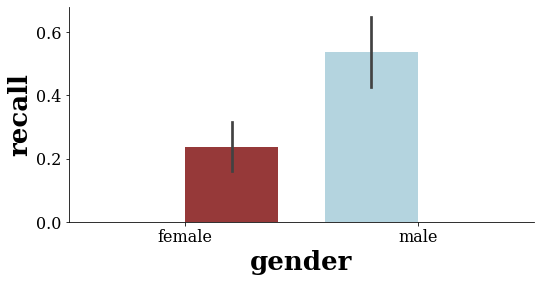

In [18]:
g = sns.catplot(x="gender", y="recall",
                data=results_de, kind="bar", hue='gender',
                hue_order = ['male', 'female'],
                palette=sns.color_palette(['lightblue', 'brown']),
                height=4.5, aspect=1.8)
fig = g.fig
axes = g.axes

#fig.suptitle('German: Recall for WinoMT professions in target language vs. number of tokens ', y=1.1)
#axes[0,0].xaxis.label.set_visible(False)
#axes[0,2].xaxis.label.set_visible(False)
plt.tight_layout()
# plt.savefig(os.path.join('figures','diverse_script_barplot_d6' + '.pdf'), dpi=300)

plt.show()

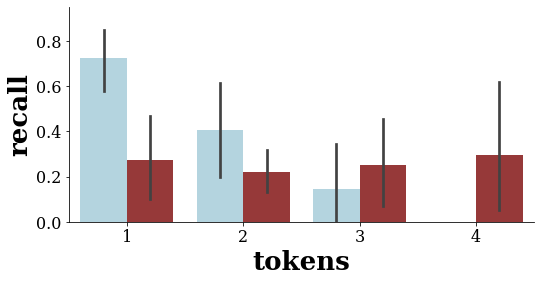

In [19]:
g = sns.catplot(x="tokens", y="recall",
                data=results_de, kind="bar", hue='gender', 
                hue_order = ['male', 'female'],
                palette=sns.color_palette(['lightblue', 'brown']),
                height=4.5, aspect=1.8, legend=False)
fig = g.fig
axes = g.axes

#fig.suptitle('German: Recall for WinoMT professions in target language vs. number of tokens ', y=1.1)
#axes[0,0].xaxis.label.set_visible(False)
#axes[0,2].xaxis.label.set_visible(False)
plt.tight_layout()
# plt.savefig(os.path.join('figures','diverse_script_barplot_d6' + '.pdf'), dpi=300)
axes[0,0].set_xlim(left=-0.5, right=3.5)
axes[0,0].set_ylim(bottom=0., top=.95)
plt.savefig(os.path.join('..','graphs','graph_6_per_gender_German.pdf'), dpi=300)

plt.show()

# Hebrew

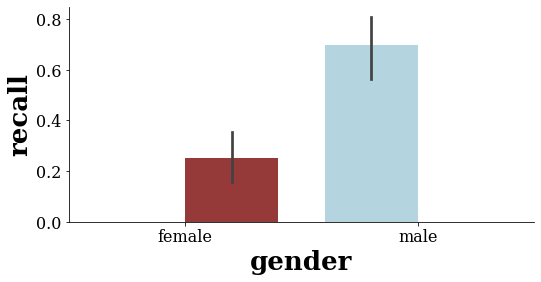

In [20]:
g = sns.catplot(x="gender", y="recall",
                data=results_he, kind="bar", hue='gender',
                hue_order = ['male', 'female'],
                palette=sns.color_palette(['lightblue', 'brown']),
                height=4.5, aspect=1.8)
fig = g.fig
axes = g.axes

#fig.suptitle('German: Recall for WinoMT professions in target language vs. number of tokens ', y=1.1)
#axes[0,0].xaxis.label.set_visible(False)
#axes[0,2].xaxis.label.set_visible(False)
plt.tight_layout()
# plt.savefig(os.path.join('figures','diverse_script_barplot_d6' + '.pdf'), dpi=300)

plt.show()

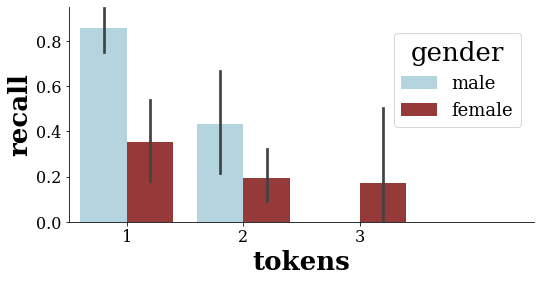

In [21]:
g = sns.catplot(x="tokens", y="recall",
                data=results_he, kind="bar", hue='gender',
                hue_order = ['male', 'female'],
                palette=sns.color_palette(['lightblue', 'brown']),
                height=4.5, aspect=1.8, legend=False)
fig = g.fig
axes = g.axes

axes[0,0].legend(ncol=1,loc='lower right', bbox_to_anchor=(.99, 0.4), title='gender')

#fig.suptitle('Hebrew: Recall for WinoMT professions in target language vs. number of tokens ', y=1.1)
#axes[0,0].xaxis.label.set_visible(False)
#axes[0,2].xaxis.label.set_visible(False)
plt.tight_layout()
# plt.savefig(os.path.join('figures','diverse_script_barplot_d6' + '.pdf'), dpi=300)
axes[0,0].set_xlim(left=-0.5, right=3.5)
axes[0,0].set_ylim(bottom=0., top=.95)
plt.savefig(os.path.join('..','graphs','graph_6_per_gender_Hebrew.pdf'), dpi=300)

plt.show()

divided by stereotype

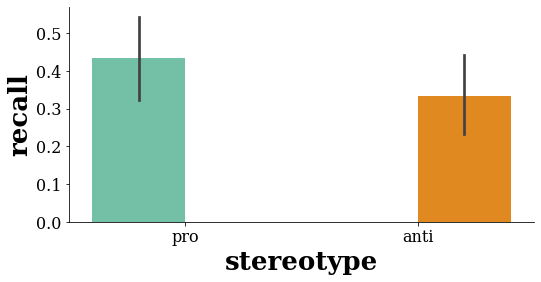

In [22]:
g = sns.catplot(x="stereotype", y="recall",
                data=results_de, kind="bar", hue='stereotype',
                hue_order = ['pro', 'anti'],
                palette=sns.color_palette(['mediumaquamarine', 'darkorange']),
                height=4.5, aspect=1.8)
fig = g.fig
axes = g.axes

#fig.suptitle('German: Recall for WinoMT professions in target language vs. number of tokens ', y=1.1)
#axes[0,0].xaxis.label.set_visible(False)
#axes[0,2].xaxis.label.set_visible(False)
plt.tight_layout()
# plt.savefig(os.path.join('figures','diverse_script_barplot_d6' + '.pdf'), dpi=300)

plt.show()

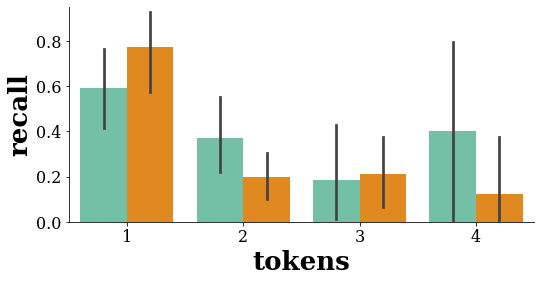

In [23]:
g = sns.catplot(x="tokens", y="recall",
                data=results_de, kind="bar", hue='stereotype',
                hue_order = ['pro', 'anti'],
                palette=sns.color_palette(['mediumaquamarine', 'darkorange']),
                height=4.5, aspect=1.8, legend=False)
fig = g.fig
axes = g.axes

#fig.suptitle('German: Recall for WinoMT professions in target language vs. number of tokens ', y=1.1)
#axes[0,0].xaxis.label.set_visible(False)
#axes[0,2].xaxis.label.set_visible(False)
plt.tight_layout()
# plt.savefig(os.path.join('figures','diverse_script_barplot_d6' + '.pdf'), dpi=300)
axes[0,0].set_xlim(left=-0.5, right=3.5)
axes[0,0].set_ylim(bottom=0., top=.95)
plt.savefig(os.path.join('..','graphs','graph_6_per_streotype_German.pdf'), dpi=300)

plt.show()

# Hebrew

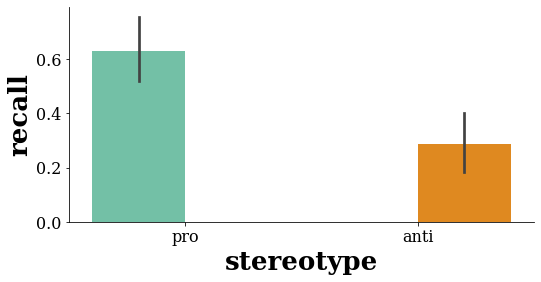

In [24]:
g = sns.catplot(x="stereotype", y="recall",
                data=results_he, kind="bar", hue='stereotype',
                hue_order = ['pro', 'anti'],
                palette=sns.color_palette(['mediumaquamarine', 'darkorange']),
                height=4.5, aspect=1.8)
fig = g.fig
axes = g.axes

#fig.suptitle('German: Recall for WinoMT professions in target language vs. number of tokens ', y=1.1)
#axes[0,0].xaxis.label.set_visible(False)
#axes[0,2].xaxis.label.set_visible(False)
plt.tight_layout()
# plt.savefig(os.path.join('figures','diverse_script_barplot_d6' + '.pdf'), dpi=300)

plt.show()

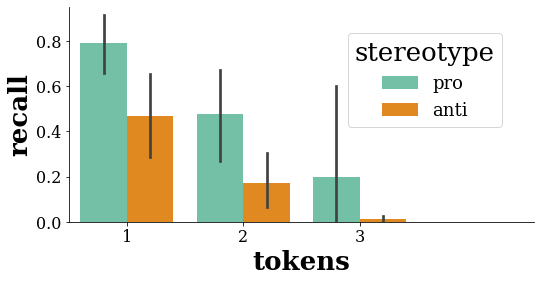

In [25]:
g = sns.catplot(x="tokens", y="recall",
                data=results_he, kind="bar", hue='stereotype',
                hue_order = ['pro', 'anti'],
                palette=sns.color_palette(['mediumaquamarine', 'darkorange']),
                height=4.5, aspect=1.8, legend=False)
fig = g.fig
axes = g.axes
axes[0,0].legend(ncol=1,loc='lower right', bbox_to_anchor=(.95, 0.4), title='stereotype')
#fig.suptitle('German: Recall for WinoMT professions in target language vs. number of tokens ', y=1.1)
#axes[0,0].xaxis.label.set_visible(False)
#axes[0,2].xaxis.label.set_visible(False)
plt.tight_layout()
# plt.savefig(os.path.join('figures','diverse_script_barplot_d6' + '.pdf'), dpi=300)
axes[0,0].set_xlim(left=-0.5, right=3.5)
axes[0,0].set_ylim(bottom=0., top=.95)
plt.savefig(os.path.join('..','graphs','graph_6_per_streotype_Hebrew.pdf'), dpi=300)
plt.show()

# Exploratory analysis

<AxesSubplot:>

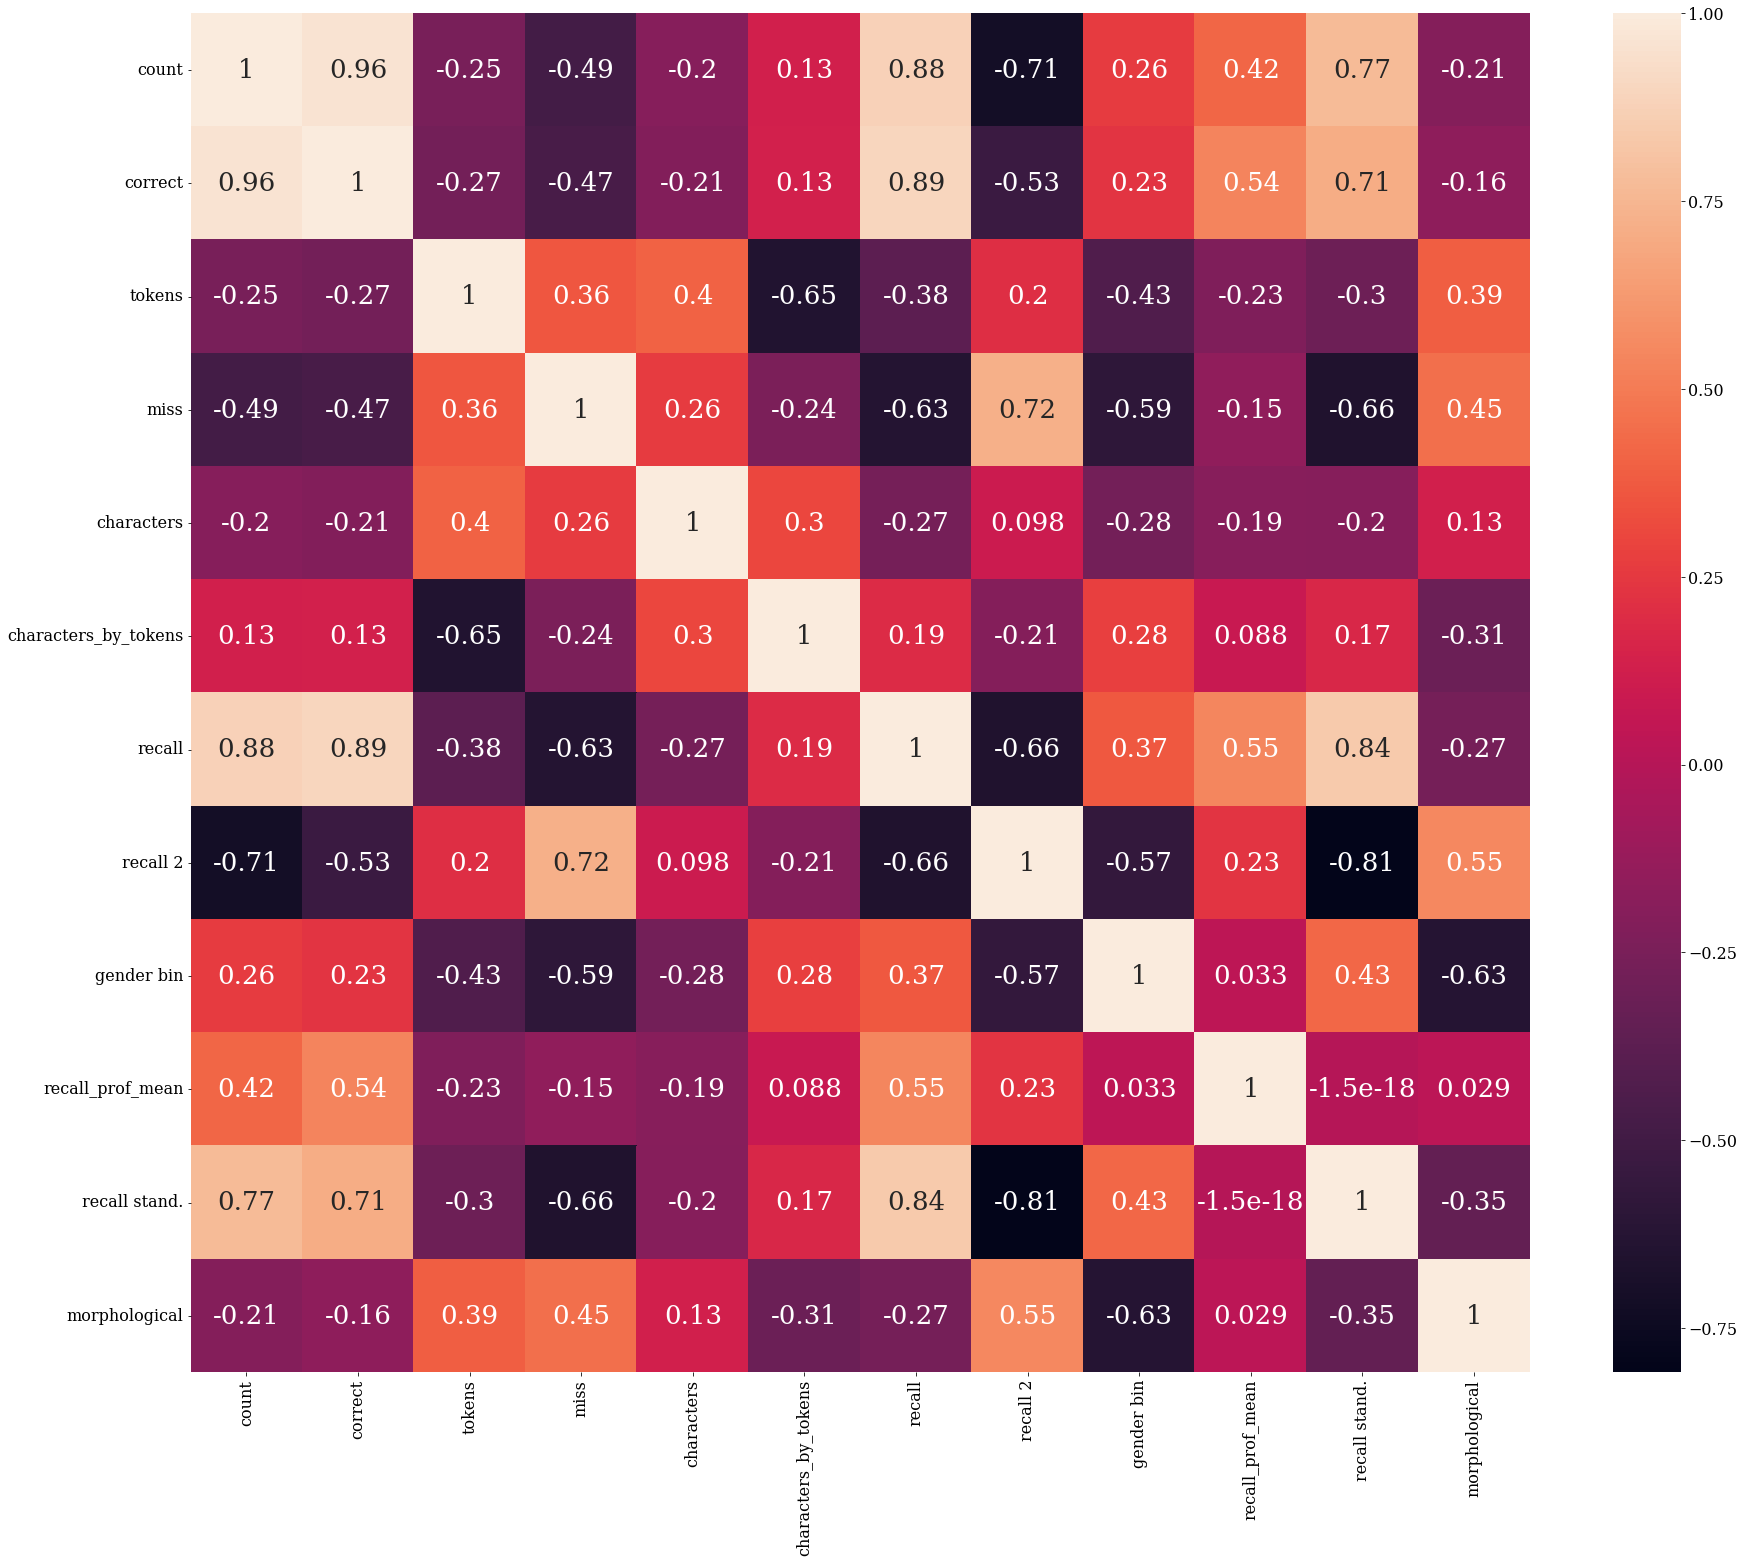

In [26]:
cormat = results_de.corr()
round(cormat,2)
plt.figure(figsize = (30,25))
sns.heatmap(cormat, annot=True)

<AxesSubplot:>

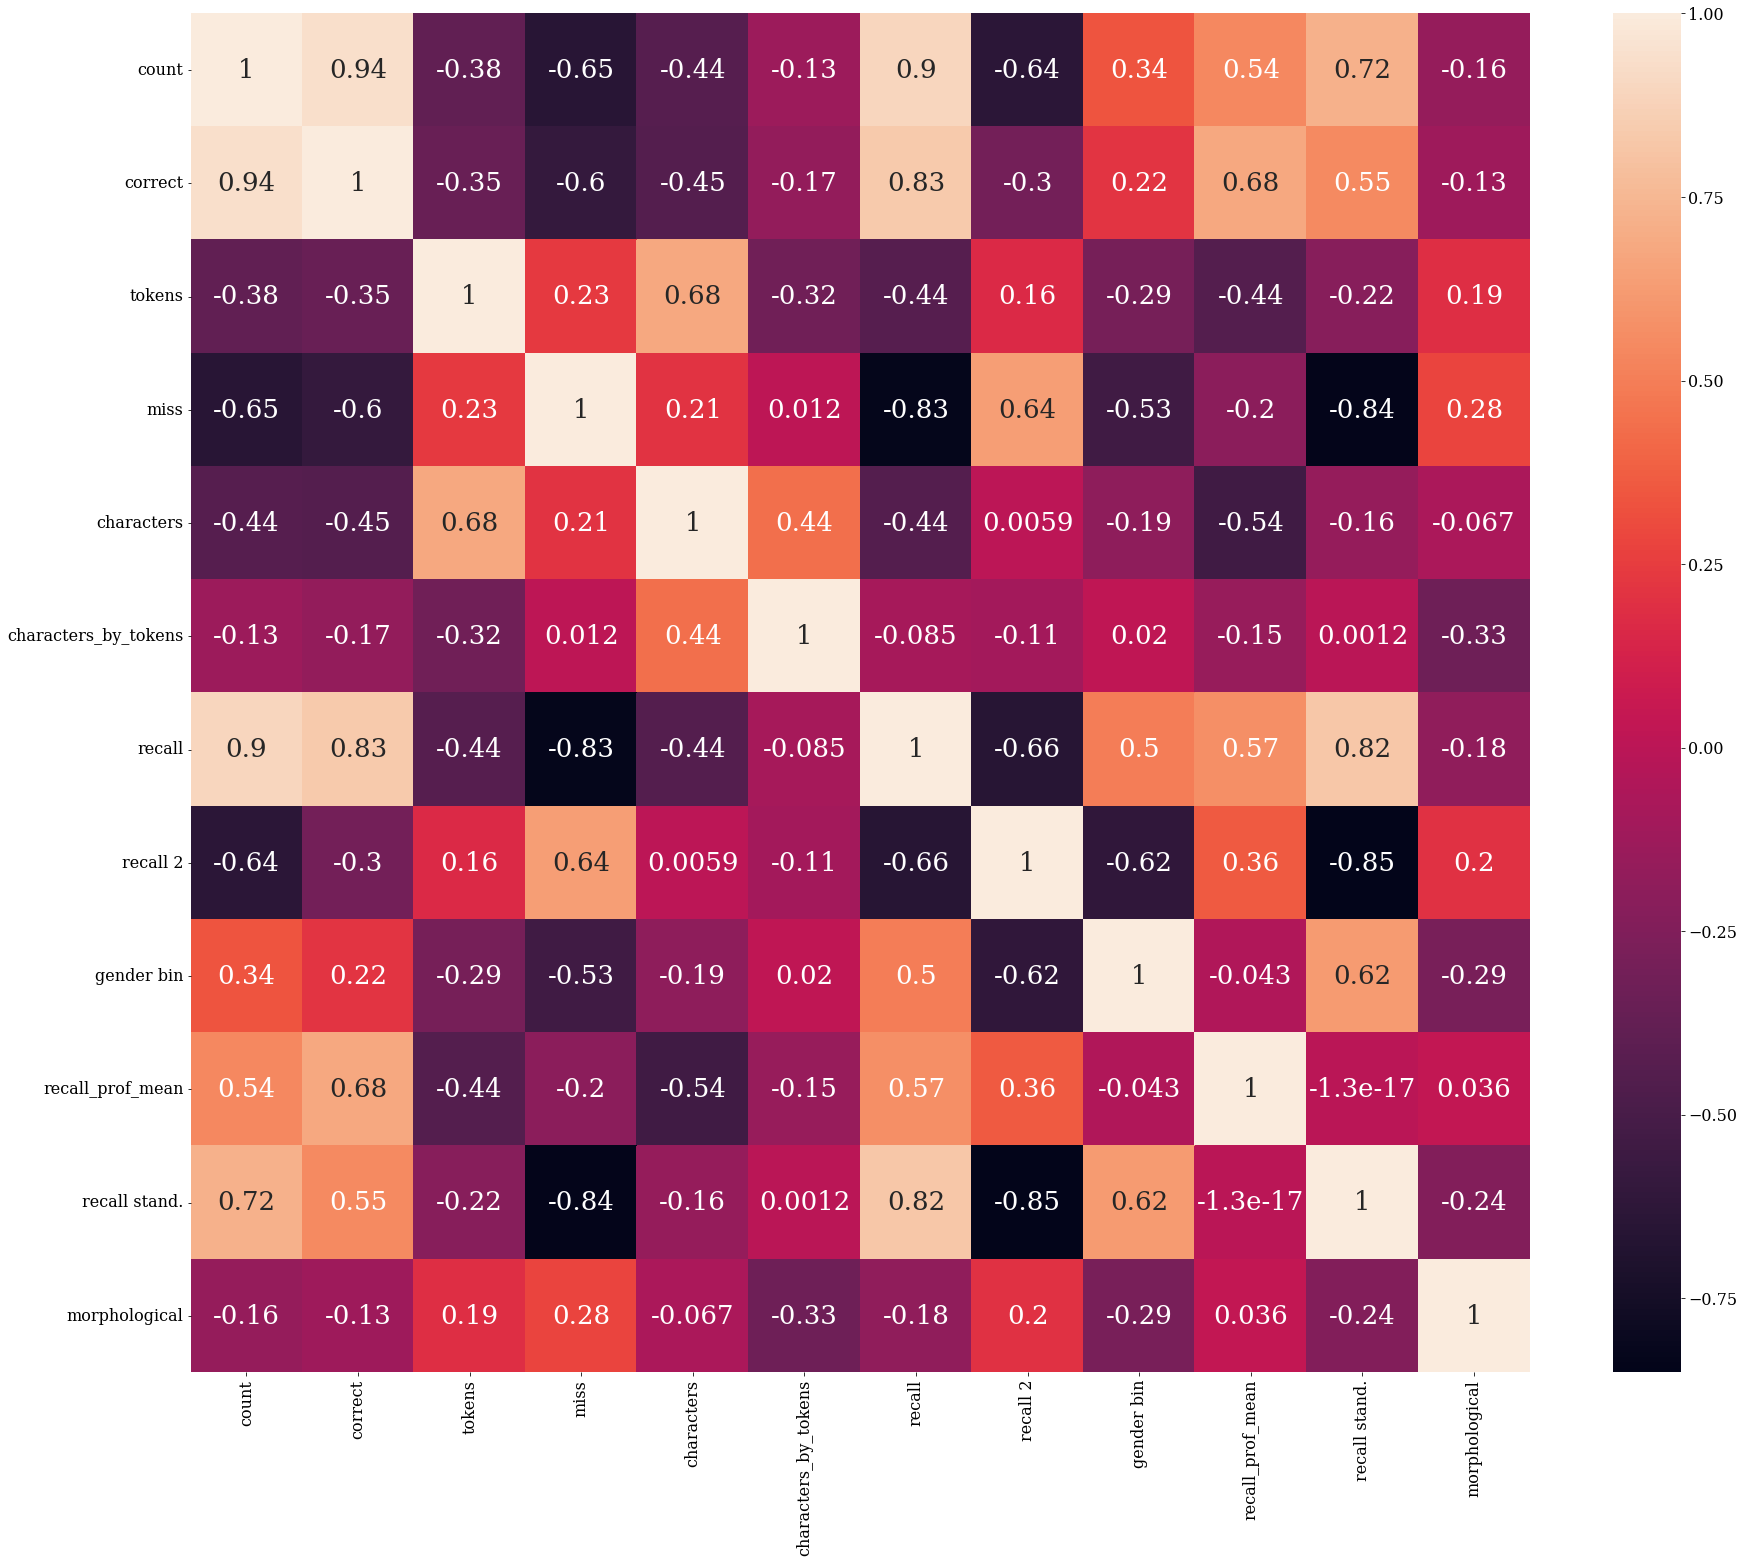

In [27]:
cormat = results_he.corr()
round(cormat,2)
plt.figure(figsize = (30,25))
sns.heatmap(cormat, annot=True)